# Project 3. Credit Card Default Detection

### Objective
* predict whether a credit card would be default(坏账) or not. / credit default, 还不起钱, 造成坏账.
* a classification problem: Binary problem 0/1.

### Steps
1. Perform feature engineering.
    * Discern the categorical and continuous variables.
    * Check if features have linear relationship between each other.
2. Choose a classifier.
3. Find a way to deal with imbalanced data in target

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### 1. Load Data

There are three datasets available:
* test.csv: testing dataset, to test, build, validate models
* train.csv: training dataset, to impute predictions
* testGroundTruth (optional)

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
print("train shape is:",train.shape)
print("test shape is:",test.shape)
#train: train+validation
#test: prediction

train shape is: (25000, 25)
test shape is: (5000, 24)


In [3]:
train.head(5)

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,200000,2,3,1,53,0,0,0,0,...,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,...,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,...,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,...,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,...,332,416,416,0,416,332,500,3500,832,0


In [4]:
train.dtypes

id     int64
X1     int64
X2     int64
X3     int64
X4     int64
X5     int64
X6     int64
X7     int64
X8     int64
X9     int64
X10    int64
X11    int64
X12    int64
X13    int64
X14    int64
X15    int64
X16    int64
X17    int64
X18    int64
X19    int64
X20    int64
X21    int64
X22    int64
X23    int64
Y      int64
dtype: object

### 2. Explore data (EDA)

### 2.1 Data Quality Check

We perform the Data Quality Check from the following aspects:
* Completeness (check missing values)
* Uniqueness (check duplicates)
* Skewness (check Numeric Distribution Skewness)

In [5]:
# No null values
train.isna().sum()

id     0
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

In [6]:
# No duplicates
len(train.id)==len(set(train.id))

True

In [7]:
# check distribution
# imbalanced dataset
print (train.Y.value_counts())
print (train.Y.value_counts(normalize=True))

0    19452
1     5548
Name: Y, dtype: int64
0    0.77808
1    0.22192
Name: Y, dtype: float64


### 2.2 Obj/Num Features

Based on the business context, we categorize all the variables into following groups:

**Demographic**:
  * Gender(Obj): M/F
  * Education(Obj): High school/University/Grad School/Others
  * Marital(Obj): Single/Married/Others
  * Age(Num)
  
**Credit**:
  * Credit_line(Num)
  
**Payment**:
  * Sep_2015~Apr_2015(Obj): Ahead/On_time/Delay
  * 201509_S~201504_S(Num)
  * 201509_P~201504_P(Num)

=>**Metrics**:
  * Calculated(Num 0-1): Over_credit? Bills/Credit_line
  * Amount of Payment(Num 0-1): Partially paid/full paid: 201509_P~201504_P/B
  * Timing of Payment(Obj): Ahead/On_time/Delay

In [8]:
obj_var=list(train.select_dtypes(np.object))
print(len(obj_var))
obj_var

0


[]

In [9]:
demogra=train.iloc[:5,2:6]
demogra

,X2,X3,X4,X5
0,2,3,1,53
1,2,3,2,39
2,2,1,2,41
3,2,2,1,43
4,1,2,2,28


In [10]:
demogra_var=demogra.columns.tolist()
demogra_var

['X2', 'X3', 'X4', 'X5']

In [11]:
payment=train.iloc[:5,6:12]
payment

,X6,X7,X8,X9,X10,X11
0,0,0,0,0,0,0
1,0,0,0,2,0,0
2,0,0,0,0,0,0
3,1,-2,-2,-1,0,0
4,-1,-1,-1,-1,-1,-1


In [12]:
payment_var=payment.columns.tolist()
payment_var

['X6', 'X7', 'X8', 'X9', 'X10', 'X11']

In [13]:
obj_var=demogra_var+payment_var
print(len(obj_var))
obj_var

10


['X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

In [14]:
num_var=list(train.select_dtypes(np.number))
print(len(num_var))
num_var

25


['id',
 'X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13',
 'X14',
 'X15',
 'X16',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X23',
 'Y']

In [15]:
num_var=list(set(num_var)-set(obj_var))
num_var.remove('id')
num_var.remove('Y')
print(len(num_var))
num_var

13


['X14',
 'X12',
 'X22',
 'X18',
 'X19',
 'X17',
 'X21',
 'X23',
 'X20',
 'X13',
 'X16',
 'X15',
 'X1']

In [16]:
target=['Y']
train[target].head()

,Y
0,0
1,0
2,0
3,0
4,0


### 2.3 Check consistency in train/test dataset

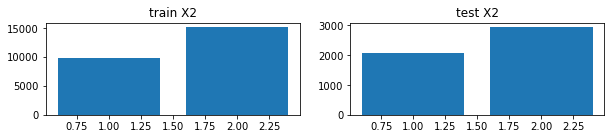

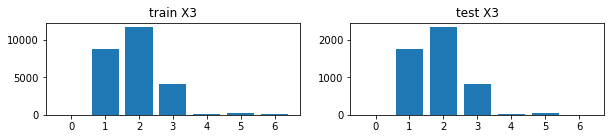

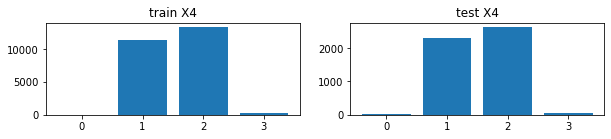

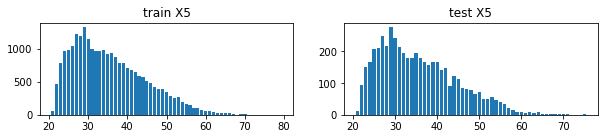

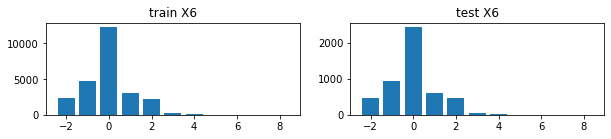

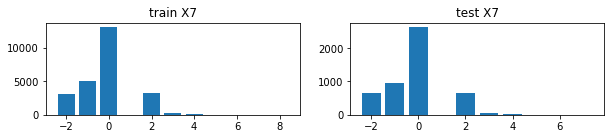

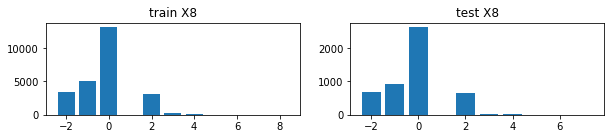

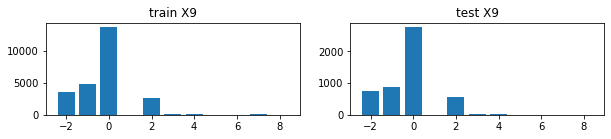

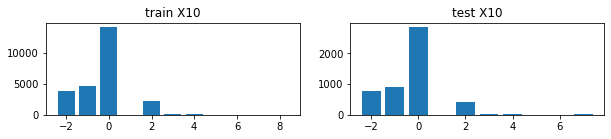

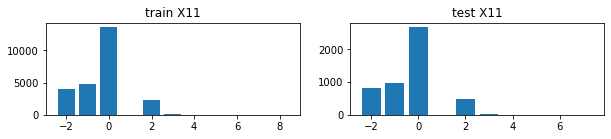

In [17]:
#obj_var
count=1
for i in range(len(obj_var)):
    fig = plt.figure(figsize=(10,20))
    
    plt.subplot(len(obj_var),2,count)
    plt.bar(train[obj_var[i]].value_counts().index, train[obj_var[i]].value_counts().values)
    plt.title("train "+obj_var[i])
    
    plt.subplot(len(obj_var),2,count+1)
    plt.bar(test[obj_var[i]].value_counts().index, test[obj_var[i]].value_counts().values)
    plt.title("test "+obj_var[i])
    count+=2

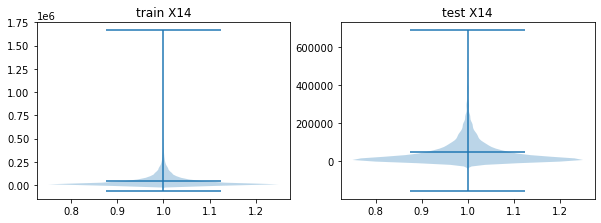

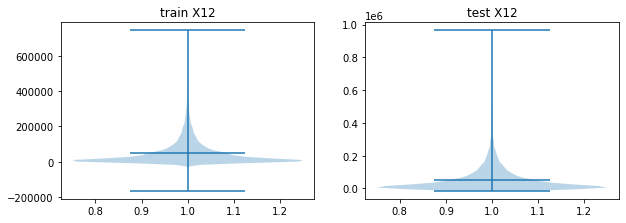

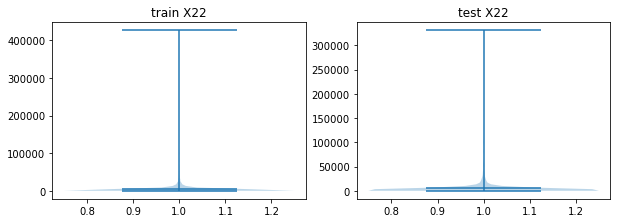

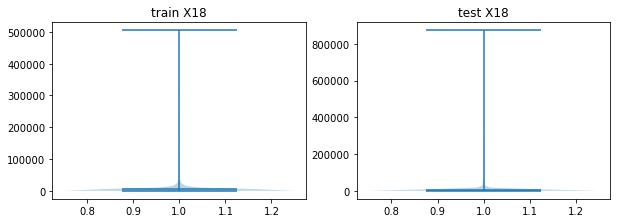

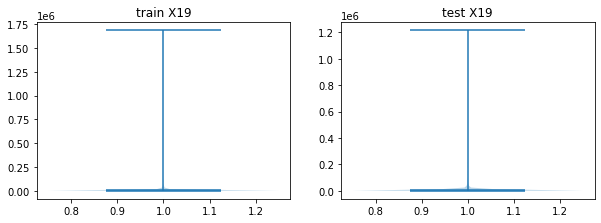

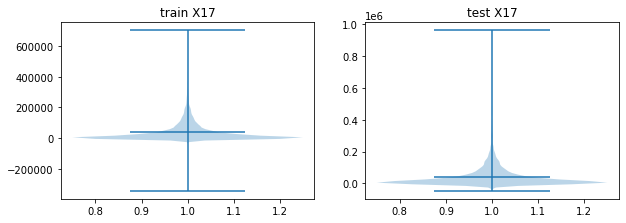

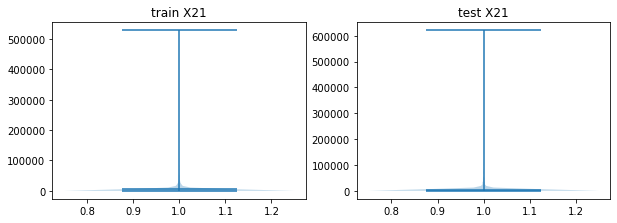

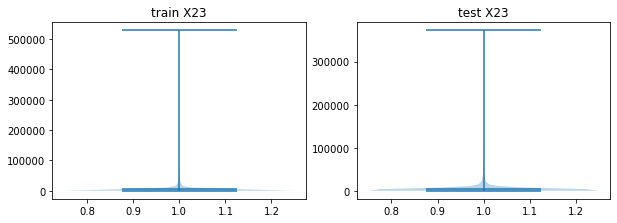

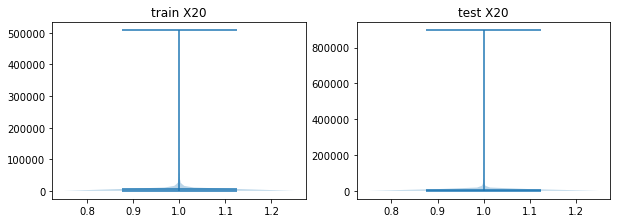

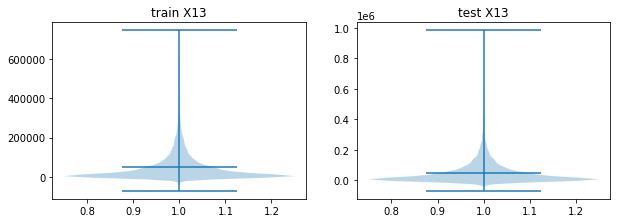

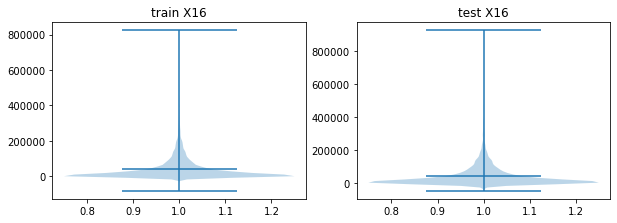

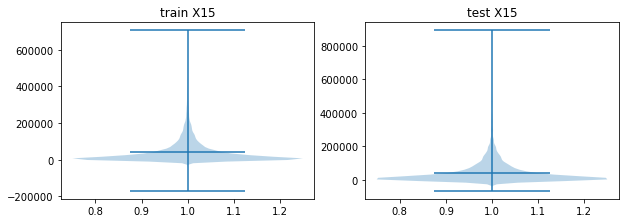

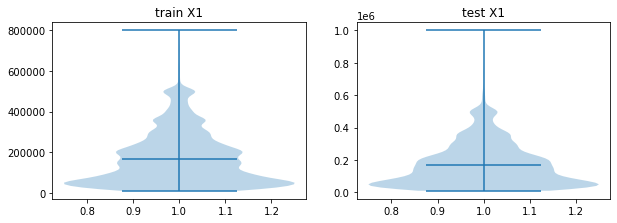

In [18]:
#num_var
count=1
for i in range(len(num_var)):
    fig = plt.figure(figsize=(10,50))
    
    plt.subplot(len(num_var),2,count)
    plt.violinplot(train[num_var[i]],showmeans=True)
    plt.title("train "+num_var[i])
    
    plt.subplot(len(num_var),2,count+1)
    plt.violinplot(test[num_var[i]],showmeans=True)
    plt.title("test "+num_var[i])
    count+=2

### 2.4 Check Correlation

In [19]:
train[num_var].corr()

,X14,X12,X22,X18,X19,X17,X21,X23,X20,X13,X16,X15,X1
X14,1.000000,0.891848,0.183451,0.254755,0.339935,0.851158,0.147199,0.185457,0.130879,0.926157,0.880541,0.921408,0.286339
X12,0.891848,1.000000,0.157716,0.149507,0.100359,0.799414,0.162488,0.184665,0.150908,0.953280,0.828177,0.859735,0.287309
X22,0.183451,0.157716,1.000000,0.160538,0.201817,0.305616,0.164027,0.150542,0.176050,0.153842,0.141638,0.161757,0.217500
X18,0.254755,0.149507,0.160538,1.000000,0.213567,0.200899,0.140462,0.170909,0.195380,0.288755,0.219541,0.239665,0.206108
X19,0.339935,0.100359,0.201817,0.213567,1.000000,0.172637,0.114812,0.148240,0.173175,0.101627,0.180056,0.209593,0.183218
X17,0.851158,0.799414,0.305616,0.200899,0.172637,1.000000,0.256859,0.115301,0.225067,0.828596,0.945379,0.897777,0.290695
X21,0.147199,0.162488,0.164027,0.140462,0.114812,0.256859,1.000000,0.151458,0.160803,0.149683,0.296810,0.126881,0.207212
X23,0.185457,0.184665,0.150542,0.170909,0.148240,0.115301,0.151458,1.000000,0.160582,0.175980,0.168347,0.182119,0.221568
X20,0.130879,0.150908,0.176050,0.195380,0.173175,0.225067,0.160803,0.160582,1.000000,0.139564,0.244280,0.304090,0.216725
X13,0.926157,0.953280,0.153842,0.288755,0.101627,0.828596,0.149683,0.175980,0.139564,1.000000,0.856223,0.889813,0.280592


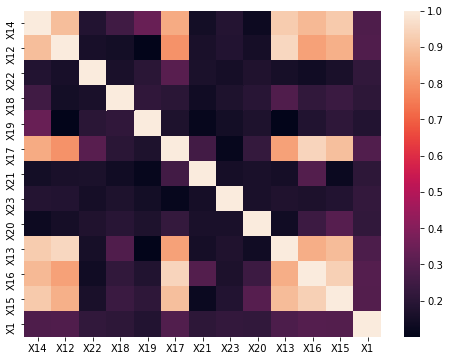

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(train[num_var].corr())

In [21]:
#如何处理unbalanced dataset, 很少delay.

### 3. Modeling

### Build a baseline model

In [22]:
from sklearn.model_selection import train_test_split
Y = train['Y']
X = train.drop(['Y', 'id'], axis= 1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
RF = RandomForestClassifier(class_weight = {0:1, 1:3})
RF = RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3923
           1       0.64      0.33      0.44      1077

    accuracy                           0.82      5000
   macro avg       0.74      0.64      0.66      5000
weighted avg       0.80      0.82      0.79      5000



### Tuning parameter: Grid Searching

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring = 'f1_weighted',
                                     verbose = 10,
                                     n_jobs = n_jobs,
                                     iid = True,
                                     cv = cv)
    model.fit(x_train, y_train)   
    return model

In [25]:
param_grid = {'n_estimators':[100,300,500],
             'criterion':['gini', 'entropy'],
             'class_weight': [{0:1, 1:3}]}

RF = search_model(X.values
            , Y.values
            , RandomForestClassifier()
            , param_grid
            , -1
            , 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.0min remaining:   27.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.7min finished
/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [27]:
print("Best score: %0.3f" % RF.best_score_)
print("Best parameters set:", RF.best_params_)

Best score: 0.795
Best parameters set: {'class_weight': {0: 1, 1: 3}, 'criterion': 'entropy', 'n_estimators': 500}


### Model Ensemble

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(n_estimators = 300, criterion = 'entropy',class_weight = {0:1, 1:3})
clf2 = KNeighborsClassifier(n_neighbors=3)
clf3 = LogisticRegression (class_weight = {0:1, 1:3})
# results from your gridsearch
eclf = VotingClassifier(estimators=[('Random_Forest',clf1), ('KNN', clf2),('Logistic', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['Random_Forest', 'KNN','Logistic', 'Ensemble']):
    scores = cross_val_score(clf, X, Y, cv=3, scoring='f1_weighted')
    print ("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.79 (+/- 0.00) [Random_Forest]
Accuracy: 0.71 (+/- 0.00) [KNN]


/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy: 0.70 (+/- 0.02) [Logistic]


/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Accuracy: 0.76 (+/- 0.01) [Ensemble]


#### submission

In [29]:
eclf.fit(X, Y)
y = pd.DataFrame(eclf.predict(test.drop(['id'],axis=1)), columns=['y'])
predict_data = pd.concat([y, test['id']], axis =1)
predict_data.to_csv('Submmission.csv', index=False)

/Users/xrli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
